In [21]:
import os
import copy
import glob
import pickle
import matplotlib
import collections
import brewer2mpl
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import cm
import matplotlib.pyplot as plt
import matplotlib.colors as colors

bmap = brewer2mpl.get_map('Reds', 'Sequential', 9)

%matplotlib inline

matplotlib.rc('xtick', labelsize=15) 
matplotlib.rc('ytick', labelsize=15) 
matplotlib.rcParams.update({'font.size':16})

In [2]:
df = pd.DataFrame(columns=['adhesion','polarization','density','frame','avg num neighbors','avg speed'])

In [3]:
pol_keys = [repr(int(x)) for x in np.linspace(1, 21, 21)]
pol_vals = [x for x in np.linspace(0.25, 0.55, 21)]

In [4]:
np.linspace(0.25, 0.55, 21)

array([ 0.25 ,  0.265,  0.28 ,  0.295,  0.31 ,  0.325,  0.34 ,  0.355,
        0.37 ,  0.385,  0.4  ,  0.415,  0.43 ,  0.445,  0.46 ,  0.475,
        0.49 ,  0.505,  0.52 ,  0.535,  0.55 ])

In [5]:
den_dict = {'1':100}
pol_dict = dict(zip(pol_keys,pol_vals))
adh_dict = {'a':2.0, 'b':2.15, 'c':2.3, 'd':2.45, 'e':2.6, 'f':2.75, 'g':2.9,
            '1':3.0, '2':3.15, '3':3.3, '4':3.45, '5':3.6, '6':3.75, '7':3.9, '8':4.05, '9':4.2, '10':4.35}

#### Parse data files

In [ ]:
max_iter = 2000
sims_stored = []

for den_ind in den_dict.keys():
    
    density = den_dict[den_ind]
    parent_folder = 'adh_pol_sweep'
    
    for sim_folder in glob.glob(parent_folder+os.sep+'*'+os.sep):
        
        sim_name = sim_folder.split(os.sep)[1]
        adh_ind = sim_name.split('_')[0]
        pol_ind = sim_name.split('_')[2]
        
        if adh_ind not in adh_dict.keys():
            continue
        if pol_ind not in pol_dict.keys():
            continue

        adhesion = adh_dict[adh_ind]
        polarity = pol_dict[pol_ind]
            
        sims_stored.append(sim_name)
        
        for itr in range(1, max_iter+1):
            
            c_iter = str(itr*100).zfill(6)
            velMat = pd.read_csv(os.sep.join([sim_folder, 'Velocity_'+c_iter+'.dat']), header=None)
            speeds = list()
            numCells = 0
            
            for vel in velMat.values[0]:
                numCells += 1
                if repr(vel)=='0':
                    speeds.append(0)
                else:
                    vx = np.real(complex(vel.replace('i','j')))
                    vy = np.imag(complex(vel.replace('i','j')))
                    speeds.append(np.sqrt(vx**2+vy**2))
                    
            nbdMat = pd.read_csv(os.sep.join([sim_folder, 'Neighbors_'+c_iter+'.dat']), header=None)
            num_neighbors = [int(nbd) for nbd in nbdMat.values]
            df = df.append({'adhesion':adhesion, 'polarization':polarity, 'density':density, 
                            'frame':itr, 'avg num neighbors':np.mean(num_neighbors), 
                            'avg speed':np.mean(speeds), 'number of cells':numCells}, ignore_index=True)

#### Save data

In [ ]:
df.to_pickle("sim_results.pkl")
df.head()

#### Load data

In [54]:
df = pd.read_pickle("sim_results.pkl")

In [55]:
df.head()

adhesion  polarization  density  frame  avg num neighbors  avg speed  \
0      3.45         0.355    100.0    1.0               0.72   0.026695   
1      3.45         0.355    100.0    2.0               0.76   0.026957   
2      3.45         0.355    100.0    3.0               0.82   0.027133   
3      3.45         0.355    100.0    4.0               0.86   0.027357   
4      3.45         0.355    100.0    5.0               0.94   0.026809   

   number of cells  
0            100.0  
1            100.0  
2            100.0  
3            100.0  
4            100.0

In [56]:
np.max(df['frame'])

2000.0

#### Plot avg. speed vs. number of neighbors

In [6]:
def get_time_data(sim_dir):
    cell_count = []
    cell_speed_mean = []
    cell_speed_std = []
    foi = []
    num_cells_cluster = []
    cluster_size_mean = []
    cluster_size_std = []
    for itr in range(1, 2000):
        c_iter = str(itr*100).zfill(6)
        posMat = pd.read_csv(os.sep.join([sim_dir, 'Pos_'+c_iter+'.dat']), header=None)
        position = [complex(pos.replace('i','j')) for pos in posMat.values[0]]
        velMat = pd.read_csv(os.sep.join([sim_dir, 'Velocity_'+c_iter+'.dat']), header=None)
        velocity = list()
        for vel in velMat.values[0]:
            if repr(vel)=='0':
                velocity.append(complex('0+0j'))
            else:
                velocity.append(complex(vel.replace('i','j')))
        speed = [np.sqrt(np.real(vel)**2 + np.imag(vel)**2) for vel in velocity]
        cell_count.append(len(position))
        cell_speed_mean.append(np.mean(speed))
        cell_speed_std.append(np.std(speed))
        nbdMat = pd.read_csv(os.sep.join([sim_dir, 'Neighbors_'+c_iter+'.dat']), header=None)
        num_neighbors = [int(nbd) for nbd in nbdMat.values]
        foi.append(np.true_divide(len(np.where(np.asarray(num_neighbors)==0)[0]), len(num_neighbors)))
        num_cells_cluster.append(len(np.where(np.asarray(num_neighbors)>4)[0]))
        edges = None
        if os.path.getsize(os.sep.join([sim_dir, 'EdgeX_'+c_iter+'.dat'])) > 0:
            edgexMat = pd.read_csv(os.sep.join([sim_dir, 'EdgeX_'+c_iter+'.dat']), header=None)
            edgeyMat = pd.read_csv(os.sep.join([sim_dir, 'EdgeY_'+c_iter+'.dat']), header=None)
            edges = zip(list(edgexMat[0]),list(edgexMat[1]),list(edgeyMat[0]),list(edgeyMat[1]))
    return (cell_count, cell_speed_mean, cell_speed_std, foi, num_cells_cluster)

In [7]:
def find_clusters(sim_dir, frame):
    return ('a', 'b', 'c')

In [12]:
adh_1_pol_5_rep1 = get_time_data('adh_pol_sweep/1_adh_5_pol')  # adh = 0.03, pol = 0.0031
#adh_1_pol_5_rep2 = get_time_data('spanning_run/1_adh_5_pol')   # adh = 0.03, pol = 0.0031

adh_a_pol_5_rep1 = get_time_data('adh_pol_sweep/a_adh_5_pol')  # adh = 0.02, pol = 0.0031

adh_8_pol_5_rep1 = get_time_data('adh_pol_sweep/8_adh_5_pol') # adh = 0.0405, pol = 0.0031
#adh_8_pol_5_rep2 = get_time_data('spanning_run/8_adh_5_pol')  # adh = 0.0405, pol = 0.0031

adh_21_pol_5_rep1 = get_time_data('spanning_run/21_adh_5_pol') # adh = 0.06, pol = 0.0031

In [13]:
(cell_count_m, cell_speed_mean_m, cell_speed_std_m, foi_m, num_cells_cluster_m) = adh_a_pol_5_rep1
(cell_count_s1, cell_speed_mean_s1, cell_speed_std_s1, foi_s1, num_cells_cluster_s1) = adh_1_pol_5_rep1
(cell_count_s2, cell_speed_mean_s2, cell_speed_std_s2, foi_s2, num_cells_cluster_s2) = adh_8_pol_5_rep1
(cell_count_c, cell_speed_mean_c, cell_speed_std_c, foi_c, num_cells_cluster_c) = adh_21_pol_5_rep1

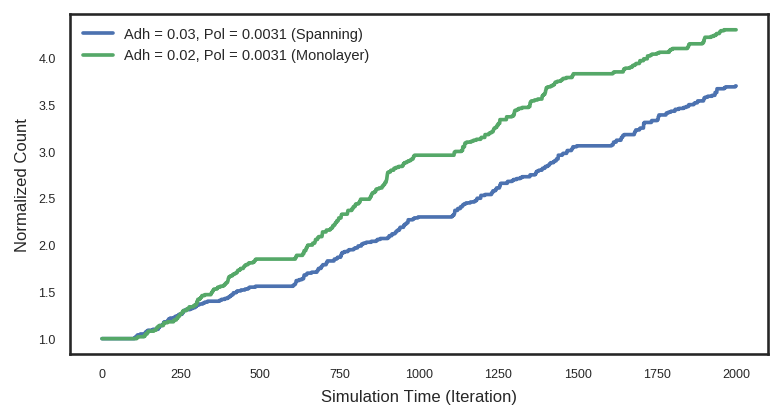

In [14]:
sns.set_style('white')
plt.figure(figsize = (6, 3), dpi=150)
plt.plot(range(1, 2000), np.true_divide(cell_count_s1, 100), label='Adh = 0.03, Pol = 0.0031 (Spanning)')
plt.plot(range(1, 2000), np.true_divide(cell_count_m, 100), label='Adh = 0.02, Pol = 0.0031 (Monolayer)')
#plt.plot(range(1, 2000), np.true_divide(cell_count_s2, 100), label='Adh = 0.04, Pol = 0.0031')
#plt.plot(range(1, 2000), np.true_divide(cell_count_c, 100), label='Adh = 0.06, Pol = 0.0031 (Compact Clusters)')
plt.xlabel('Simulation Time (Iteration)', size=8)
plt.ylabel('Normalized Count', size=8)
plt.legend(fontsize=7)
plt.tick_params(axis='both', which='major', labelsize=6)

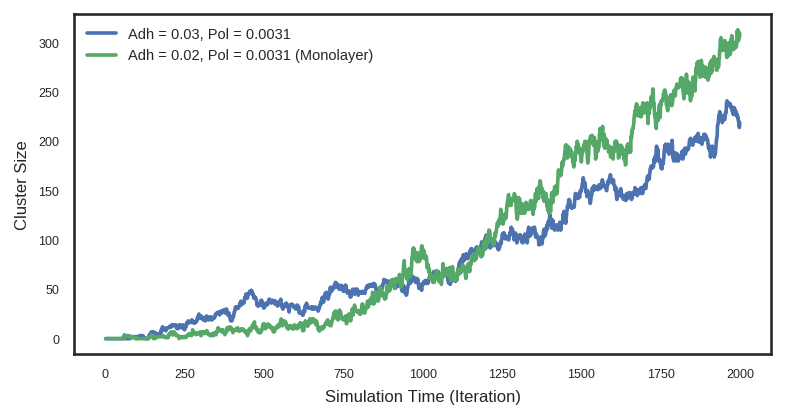

In [15]:
sns.set_style('white')
plt.figure(figsize = (6, 3), dpi=150)
plt.plot(range(1, 2000), num_cells_cluster_s1, label='Adh = 0.03, Pol = 0.0031')
plt.plot(range(1, 2000), num_cells_cluster_m, label='Adh = 0.02, Pol = 0.0031 (Monolayer)')
#plt.plot(range(1, 2000), num_cells_cluster_s2, label='Adh = 0.04, Pol = 0.0031')
#plt.plot(range(1, 2000), num_cells_cluster_c, label='Adh = 0.06, Pol = 0.0031 (Compact Clusters)')
plt.xlabel('Simulation Time (Iteration)', size=8)
plt.ylabel('Cluster Size', size=8)
plt.legend(fontsize=7)
plt.tick_params(axis='both', which='major', labelsize=6)

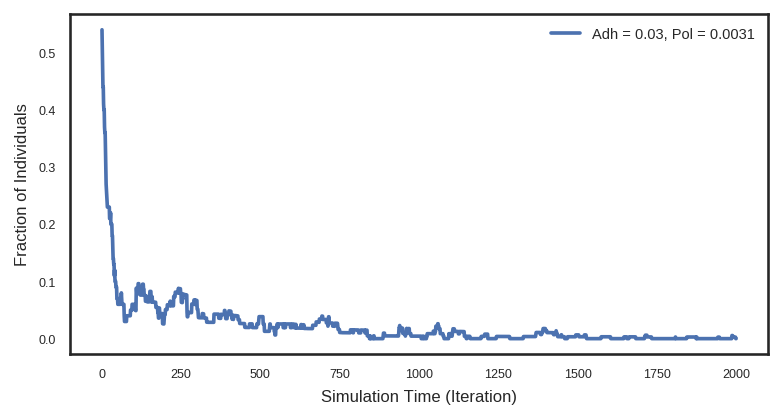

In [21]:
sns.set_style('white')
plt.figure(figsize = (6, 3), dpi=150)
plt.plot(range(1, 2000), foi_s1, label='Adh = 0.03, Pol = 0.0031')
#plt.plot(range(1, 2000), foi_m, label='Adh = 0.02, Pol = 0.0031 (Monolayer)')
#plt.plot(range(1, 2000), foi_s2, label='Adh = 0.04, Pol = 0.0031')
#plt.plot(range(1, 2000), foi_c, label='Adh = 0.06, Pol = 0.0031 (Compact Clusters)')
plt.xlabel('Simulation Time (Iteration)', size=8)
plt.ylabel('Fraction of Individuals', size=8)
plt.legend(fontsize=7)
plt.tick_params(axis='both', which='major', labelsize=6)

In [9]:
def get_neighbor_vertices(xp, yp, num_neighbors, pos):
    
    deg = 0
    tol = 1e-12
    neighbor_vertices = []
    
    for ee in edg:
        
        if (np.abs(xp - ee[0]) < tol) and (np.abs(yp - ee[2]) < tol):
            
            dest_x = ee[1]
            dest_y = ee[3]
            if dest_x == 10.0:
                for pde in edg:
                    if (np.abs(-10.0 - pde[1]) < tol) and (np.abs(dest_y - pde[3]) < tol):
                        #print "Found dest: " + repr(pde[0]) + " " + repr(pde[2])
                        dest_x = pde[0]
                        dest_y = pde[2]
            if dest_x == -10.0:
                for pde in edg:
                    if (np.abs(10.0 - pde[1]) < tol) and (np.abs(dest_y - pde[3]) < tol):
                        #print "Found dest: " + repr(pde[0]) + " " + repr(pde[2])
                        dest_x = pde[0]
                        dest_y = pde[2]
            if dest_y == -10.0:
                for pde in edg:
                    if (np.abs(dest_x - pde[1]) < tol) and (np.abs(10.0 - pde[3]) < tol):
                        #print "Found dest: " + repr(pde[0]) + " " + repr(pde[2])
                        dest_x = pde[0]
                        dest_y = pde[2]
            if dest_y == 10.0:
                for pde in edg:
                    if (np.abs(dest_x - pde[1]) < tol) and (np.abs(-10.0 - pde[3]) < tol):
                        #print "Found dest: " + repr(pde[0]) + " " + repr(pde[2])
                        dest_x = pde[0]
                        dest_y = pde[2]
            
            idx_dest_x = np.where(np.abs(np.real(pos) - dest_x) < tol)[0]
            idx_dest_y = np.where(np.abs(np.imag(pos) - dest_y) < tol)[0]
            
            if len(idx_dest_x) == 1 and len(idx_dest_y) == 1:
                if idx_dest_x[0] == idx_dest_y[0]:
                    neighbor_vertices.append(idx_dest_x[0])
                    deg = deg + 1
            else:
                if len(idx_dest_x) > 0 and len(idx_dest_y) > 0:
                    res = list(set(idx_dest_x).intersection(set(idx_dest_y)))
                    if len(res) == 1:
                        neighbor_vertices.append(res[0])
                        deg = deg + 1
                    else:
                        print "Did not work"
                        print idx_dest_x
                        print idx_dest_y
                        print ""
                else:
                    print "Did not work"
                    print idx_dest_x
                    print idx_dest_y
                    print ""
                    
    #print(num_neighbors, deg) 
    
    if (num_neighbors != deg):
        print "Something went horribly wrong"
        
    return neighbor_vertices

def get_frame_data(sim_dir, itr):
    
    c_iter = str(itr*100).zfill(6)
    posMat = pd.read_csv(os.sep.join([sim_dir, 'Pos_'+c_iter+'.dat']), header=None)
    position = [complex(pos.replace('i','j')) for pos in posMat.values[0]]
    velMat = pd.read_csv(os.sep.join([sim_dir, 'Velocity_'+c_iter+'.dat']), header=None)
    velocity = list()
    for vel in velMat.values[0]:
        if repr(vel)=='0':
            velocity.append(complex('0+0j'))
        else:
            velocity.append(complex(vel.replace('i','j')))
    nbdMat = pd.read_csv(os.sep.join([sim_dir, 'Neighbors_'+c_iter+'.dat']), header=None)
    num_neighbors = [int(nbd) for nbd in nbdMat.values]
    edges = None
    
    if os.path.getsize(os.sep.join([sim_dir, 'EdgeX_'+c_iter+'.dat'])) > 0:
        edgexMat = pd.read_csv(os.sep.join([sim_dir, 'EdgeX_'+c_iter+'.dat']), header=None)
        edgeyMat = pd.read_csv(os.sep.join([sim_dir, 'EdgeY_'+c_iter+'.dat']), header=None)
        edges = zip(list(edgexMat[0]),list(edgexMat[1]),list(edgeyMat[0]),list(edgeyMat[1]))
        
    return (position, velocity, num_neighbors, edges)

def visualize_frame(sim_dir, itr, disp):
    
    itr_s = str(itr).zfill(4)
    data = get_frame_data(sim_dir, itr)
    position = data[0]
    velocity = data[1]
    num_neighbors = data[2]
    edges = data[3]
    cdata = list()
    for nbd in num_neighbors:
        if nbd == 0:
            cdata.append('indianred')
        elif nbd < 4:
            cdata.append('royalblue')
        else:
            cdata.append('seagreen')
    plt.figure(figsize=(2,2), dpi=200)
    plt.scatter(np.real(position), np.imag(position), color=cdata, s=8)
    if edges is not None:
        for e in edges:
            plt.plot([e[0], e[1]], [e[2], e[3]], marker=None, linewidth=0.75, color='gray', alpha=0.4)
    plt.xticks([])
    plt.yticks([])
    plt.xlim([-10.1, 10.1])
    plt.ylim([-10.1, 10.1])
    
    if disp:
        plt.show()
    else:
        plt.savefig(sim_dir+'_plots'+os.sep+itr_s+'.png', bbox_inches='tight')
        
def save_frame(sim_dir, itr, name):
    
    itr_s = str(itr).zfill(4)
    data = get_frame_data(sim_dir, itr)
    position = data[0]
    velocity = data[1]
    num_neighbors = data[2]
    edges = data[3]
    cdata = list()
    for nbd in num_neighbors:
        if nbd == 0:
            cdata.append('indianred')
        elif nbd < 4:
            cdata.append('royalblue')
        else:
            cdata.append('seagreen')
    plt.figure(figsize=(2,2), dpi=600)
    plt.rcParams["axes.grid"] = True
    plt.scatter(np.real(position), np.imag(position), color=cdata, s=8)
    if edges is not None:
        for e in edges:
            plt.plot([e[0], e[1]], [e[2], e[3]], marker=None, linewidth=0.75, color='gray', alpha=0.4)
    plt.xticks([])
    plt.yticks([])
    plt.xlim([-10.1, 10.1])
    plt.ylim([-10.1, 10.1])
    plt.rcParams["axes.edgecolor"] = "black"
    plt.rcParams["axes.linewidth"] = 1
    ax = plt.gca()
    ax.spines['bottom'].set_visible(True)
    plt.savefig(name, bbox_inches='tight', transparent=True)

In [107]:
Rgy = list()
csize = list()
frame_list = list()

for itr in range(50, 700):
    
    (pos, vel, nn, edg) = get_frame_data('adh_pol_sweep/1_adh_5_pol', itr)
    
    graphs = list()
    marked_vertices = np.zeros(len(pos))

    for ppi in range(len(pos)):

        if marked_vertices[ppi] == 1:
            continue

        pp = pos[ppi]

        xp = np.real(pp)
        yp = np.imag(pp)
        num_neighbors = nn[ppi]

        #print(xp, yp)
        graph = []
        graph.append(pp)
        marked_vertices[ppi] = 1

        neighbor_vertices = get_neighbor_vertices(xp, yp, num_neighbors, pos)

        while(len(neighbor_vertices) != 0):

            vert = neighbor_vertices.pop(0)
            if marked_vertices[vert] == 1:
                continue
            graph.append(pos[vert])
            marked_vertices[vert] = 1

            xnp = np.real(pos[vert])
            ynp = np.imag(pos[vert])
            num_neighbors_p = nn[vert]
            next_neighbors = get_neighbor_vertices(xnp, ynp, num_neighbors_p, pos)

            for n_vert in next_neighbors:
                if marked_vertices[n_vert] == 1:
                    continue
                else:
                    neighbor_vertices.append(n_vert)

        graphs.append(graph)
        
    #print 'Itr: ' + repr(itr) + ' Total number of connected components: ' + repr(len(graphs))
        
    num_clusters = 0

    for gc in range(len(graphs)):

        g = graphs[gc]

        xp = np.real(g)
        yp = np.imag(g)

        cluster_size = len(xp)
        
        prev_xCOM = None
        prev_yCOM = None
        diff_COM = None

        while (diff_COM == None or diff_COM > 0.1):
        
            xCOM = np.true_divide(np.sum(xp), cluster_size)
            yCOM = np.true_divide(np.sum(yp), cluster_size)
            xnew = xp - xCOM
            ynew = yp - yCOM

            for ii in range(len(xnew)):
                if xnew[ii] < -10:
                    xnew[ii] = 20.0 + xnew[ii]
                if xnew[ii] > 10:
                    xnew[ii] = xnew[ii] - 20.0

            for ii in range(len(ynew)):
                if ynew[ii] < -10:
                    ynew[ii] = 20.0 + ynew[ii]
                if ynew[ii] > 10:
                    ynew[ii] = ynew[ii] - 20.0

            prev_xCOM = xCOM
            prev_yCOM = yCOM
            xCOM = np.true_divide(np.sum(xnew), cluster_size)
            yCOM = np.true_divide(np.sum(ynew), cluster_size)
            diff_COM = np.sqrt((xCOM-prev_xCOM)**2 + (yCOM-prev_yCOM)**2)
            xp = xnew
            yp = ynew

        Rgy_Sq = 0.0
        for (xpp, ypp) in zip(xnew, ynew):
            Rgy_Sq += (xpp-xCOM)**2 + (ypp-yCOM)**2
        Rgy_Sq = Rgy_Sq * np.true_divide(1, cluster_size)

        if cluster_size >= 4:
            
            num_clusters += 1
            
            if np.sqrt(Rgy_Sq) > 8.0:
                #print 'Itr: ' + repr(itr)
                continue
            
            Rgy.append(np.sqrt(Rgy_Sq))
            csize.append(cluster_size)
            frame_list.append(itr)
                
    #print 'Itr: ' + repr(itr) + ' Number of clusters: ' + repr(num_clusters)

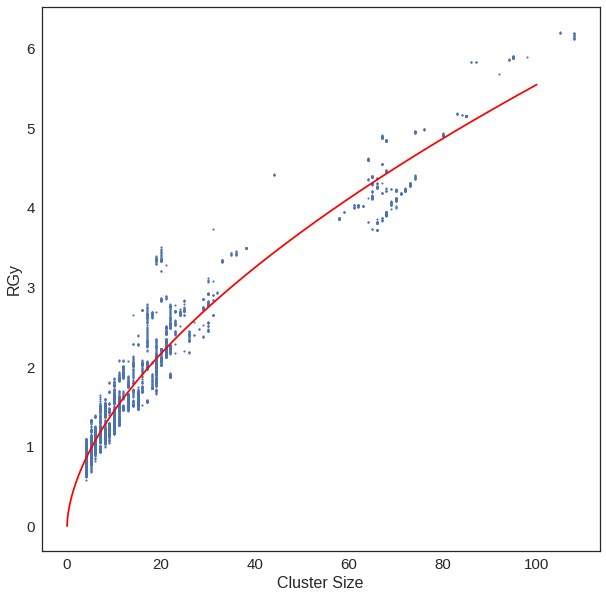

In [108]:
sns.set_style("white")
plt.figure(figsize=(10,10))

plt.scatter(csize, Rgy, s=3)

xs = np.linspace(0, 100, 1000)
ys = 0.3771619*xs**0.5839080
plt.plot(xs, ys, c='red')

plt.xlabel('Cluster Size', size=16)
plt.ylabel('RGy', size=16)

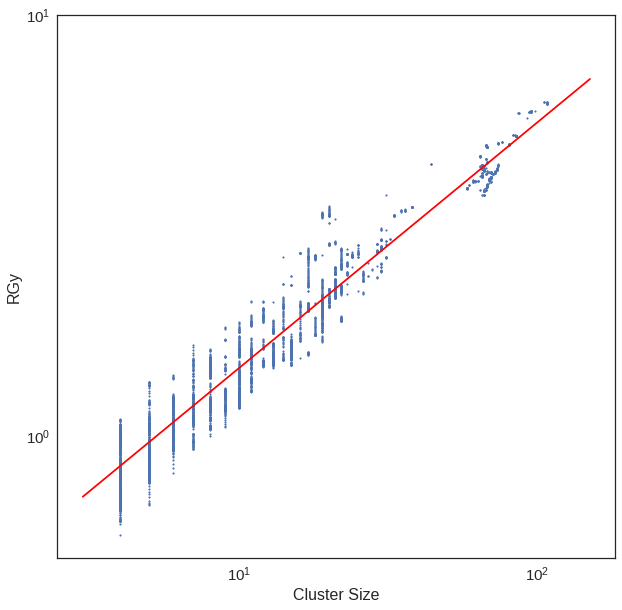

In [109]:
plt.figure(figsize=(10,10))

plt.scatter(csize, Rgy, s=3)

xs = np.linspace(3, 150, 1000)
ys = 0.3771619*xs**0.5839080
plt.plot(xs, ys, c='red')

plt.xlabel('Cluster Size', size=16)
plt.ylabel('RGy', size=16)

plt.xscale("log")
plt.yscale("log")
plt.yticks([1, 10]);

In [116]:
csize = list()
frame_list = list()

for itr in range(50, 1400):
    
    (pos, vel, nn, edg) = get_frame_data('adh_pol_sweep/1_adh_5_pol', itr)
    
    graphs = list()
    marked_vertices = np.zeros(len(pos))

    for ppi in range(len(pos)):

        if marked_vertices[ppi] == 1:
            continue

        pp = pos[ppi]

        xp = np.real(pp)
        yp = np.imag(pp)
        num_neighbors = nn[ppi]

        graph = []
        graph.append(pp)
        marked_vertices[ppi] = 1

        neighbor_vertices = get_neighbor_vertices(xp, yp, num_neighbors, pos)

        while(len(neighbor_vertices) != 0):

            vert = neighbor_vertices.pop(0)
            if marked_vertices[vert] == 1:
                continue
            graph.append(pos[vert])
            marked_vertices[vert] = 1

            xnp = np.real(pos[vert])
            ynp = np.imag(pos[vert])
            num_neighbors_p = nn[vert]
            next_neighbors = get_neighbor_vertices(xnp, ynp, num_neighbors_p, pos)

            for n_vert in next_neighbors:
                if marked_vertices[n_vert] == 1:
                    continue
                else:
                    neighbor_vertices.append(n_vert)

        graphs.append(graph)
        
    #print 'Itr: ' + repr(itr) + ' Total number of connected components: ' + repr(len(graphs))
        
    num_clusters = 0

    for gc in range(len(graphs)):

        g = graphs[gc]
        xp = np.real(g)
        yp = np.imag(g)
        
        cluster_size = len(xp)

        if cluster_size >= 4:
            
            num_clusters += 1
            
            csize.append(cluster_size)
            frame_list.append(itr)
            
    if itr % 100 == 0:           
        print 'Itr: ' + repr(itr) + ' Number of clusters: ' + repr(num_clusters)

Itr: 100 Number of clusters: 10
Itr: 200 Number of clusters: 11
Itr: 300 Number of clusters: 7
Itr: 400 Number of clusters: 6
Itr: 500 Number of clusters: 6
Itr: 600 Number of clusters: 7
Itr: 700 Number of clusters: 7
Itr: 800 Number of clusters: 4
Itr: 900 Number of clusters: 4
Itr: 1000 Number of clusters: 1
Itr: 1100 Number of clusters: 1
Itr: 1200 Number of clusters: 3
Itr: 1300 Number of clusters: 1


In [117]:
sorted_frames = np.sort(np.unique(frame_list))
mean_cluster_size = list()
std_cluster_size = list()
max_cluster_size = list()
min_cluster_size = list()
num_clusters = list()
for fr in sorted_frames:
    where_at = np.where(np.array(frame_list) == fr)[0]
    cluster_size_frame = list()
    for idx_val in where_at:
        cluster_size_frame.append(csize[idx_val])
    num_clusters.append(len(where_at))
    mean_cluster_size.append(np.mean(cluster_size_frame))
    std_cluster_size.append(np.std(cluster_size_frame))
    max_cluster_size.append(np.max(cluster_size_frame))
    min_cluster_size.append(np.min(cluster_size_frame))

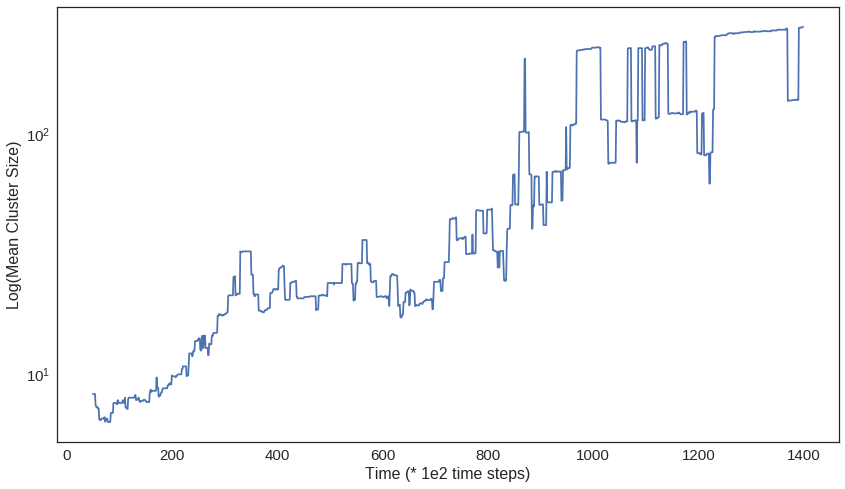

In [125]:
plt.figure(figsize=(14,8))
#plt.errorbar(sorted_frames, mean_cluster_size, yerr=np.vstack([min_cluster_size, max_cluster_size]), 
#             ecolor='red', elinewidth=0.2)
#plt.plot(sorted_frames, max_cluster_size, 'g')
#plt.plot(sorted_frames, min_cluster_size, 'g')

plt.plot(sorted_frames, mean_cluster_size)
plt.xlabel('Time (* 1e2 time steps)', size=16)
plt.yscale("log")
plt.ylabel('Log(Mean Cluster Size)', size=16)

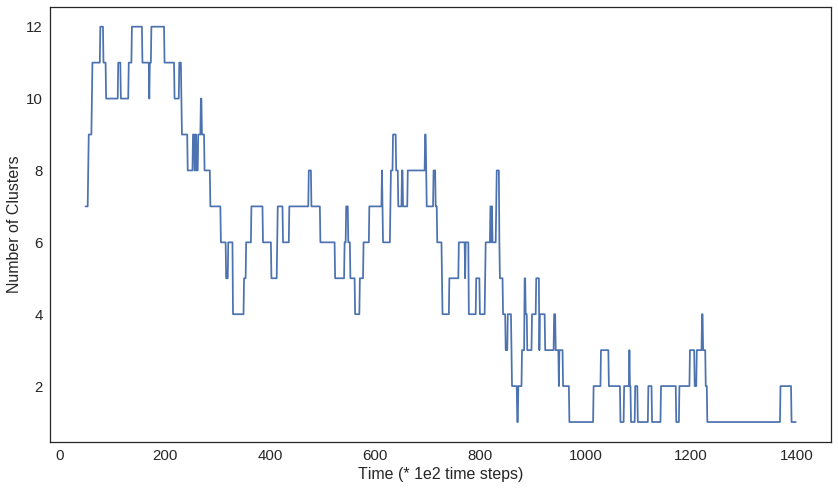

In [126]:
plt.figure(figsize=(14,8))
plt.plot(sorted_frames, num_clusters)
plt.xlabel('Time (* 1e2 time steps)', size=16)
plt.ylabel('Number of Clusters', size=16)

In [22]:
fh = open('Rgy.pkl', 'wb')
pickle.dump([Rgy, csize, frame_list], fh)
fh.close()

In [23]:
np.save("Rgy.npy", Rgy)
np.save("csize.npy", csize)

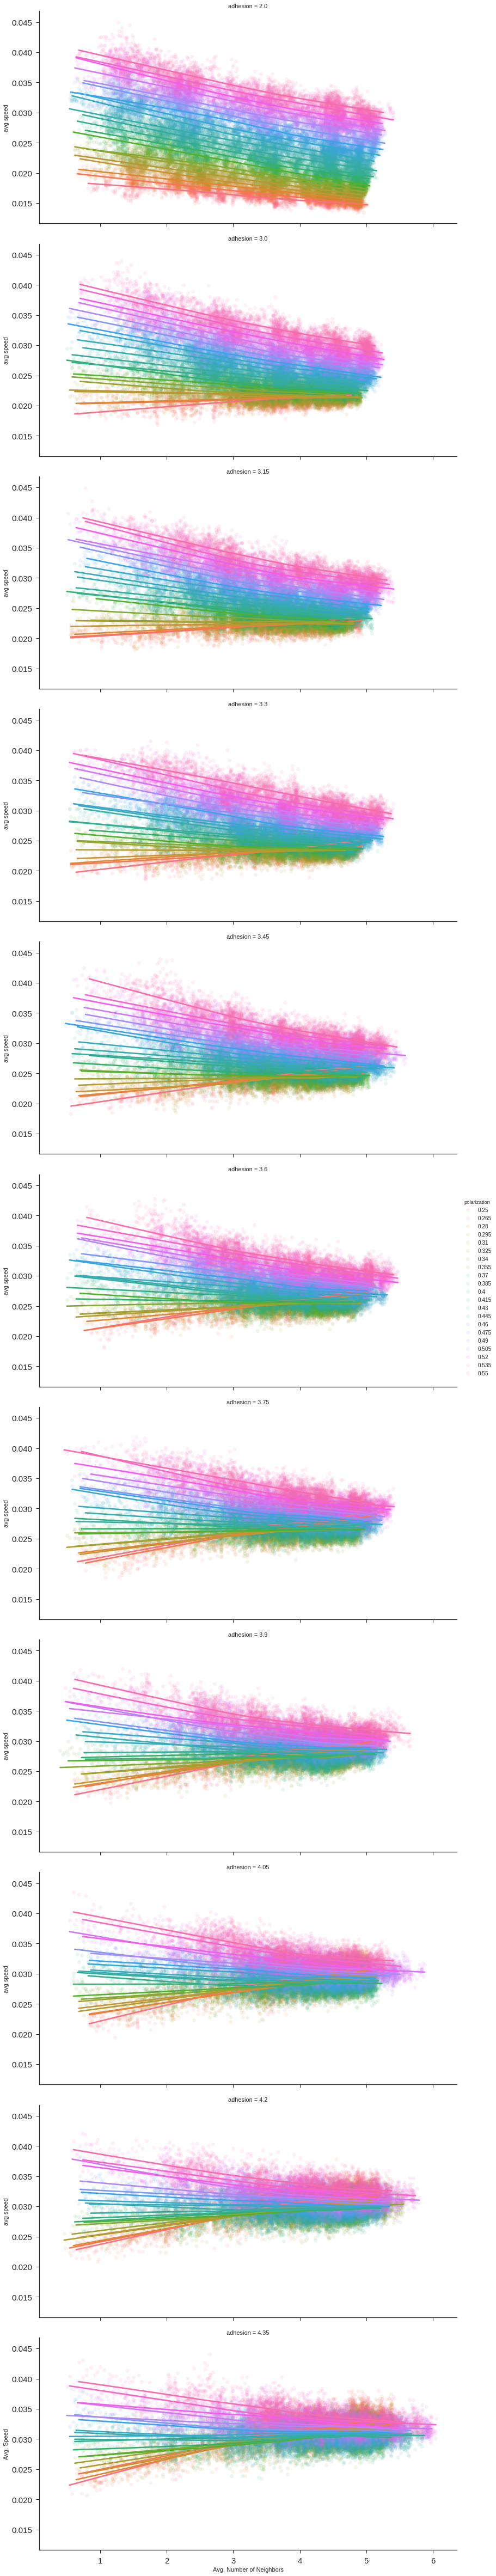

In [8]:
sns.set_style('ticks')
sns.lmplot(x="avg num neighbors", y="avg speed", data=df, markers="o", row='adhesion', 
           size=6, aspect=2, fit_reg=True, lowess=True, hue='polarization', legend=True, 
           scatter_kws={'alpha':0.1})
plt.xlabel('Avg. Number of Neighbors')
plt.ylabel('Avg. Speed')

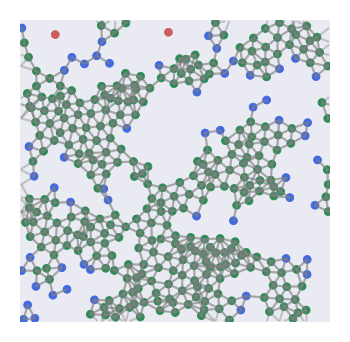

In [37]:
visualize_frame('adh_pol_sweep/1_adh_20_pol', 1970, True)

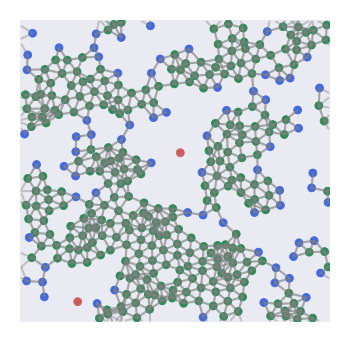

In [38]:
visualize_frame('adh_pol_sweep/1_adh_20_pol', 2000, True)

In [66]:
np.mean(get_frame_data('adh_pol_sweep/1_adh_11_pol', 1393)[2])

4.3092105263157894

In [63]:
num_nbd_vals = np.unique(df["avg num neighbors"])
x_dat = np.linspace(np.min(num_nbd_vals), np.max(num_nbd_vals), 29)
print x_dat

[ 0.4         0.60153374  0.80306748  1.00460123  1.20613497  1.40766871
  1.60920245  1.8107362   2.01226994  2.21380368  2.41533742  2.61687117
  2.81840491  3.01993865  3.22147239  3.42300613  3.62453988  3.82607362
  4.02760736  4.2291411   4.43067485  4.63220859  4.83374233  5.03527607
  5.23680982  5.43834356  5.6398773   5.84141104  6.04294479]


In [64]:
heatmap_data = np.zeros((21, 29))
heatmap_cnt = np.zeros((21, 29))
heatmap_dict = collections.defaultdict(list)

In [65]:
for index, row in df.iterrows():
    
    polarity = row['polarization']
    adhesion = row['adhesion']
    avgspeed = row['avg speed']
    avgnumneighbors = row['avg num neighbors']
    frame = int(row['frame'])
    
    for pkey in pol_dict.keys():
        if pol_dict[pkey] == polarity:
            break
            
    for akey in adh_dict.keys():
        if adh_dict[akey] == adhesion:
            break
            
    if akey not in ['a']:
        continue
            
    closestnumneighbors = min(x_dat, key=lambda x:abs(x-avgnumneighbors))
    for ind in range(len(x_dat)):
        if x_dat[ind] == closestnumneighbors:
            break
    
    heatmap_data[int(float(pkey))-1,ind] += avgspeed
    heatmap_cnt[int(float(pkey))-1,ind] += 1
    heatmap_dict[(int(float(pkey))-1,ind)].append((pkey, akey, frame))

/home/dbhaskar92/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in divide
  """Entry point for launching an IPython kernel.


Max. Speed: 0.03148211271404059
Min. Speed: 0.014858615049416308


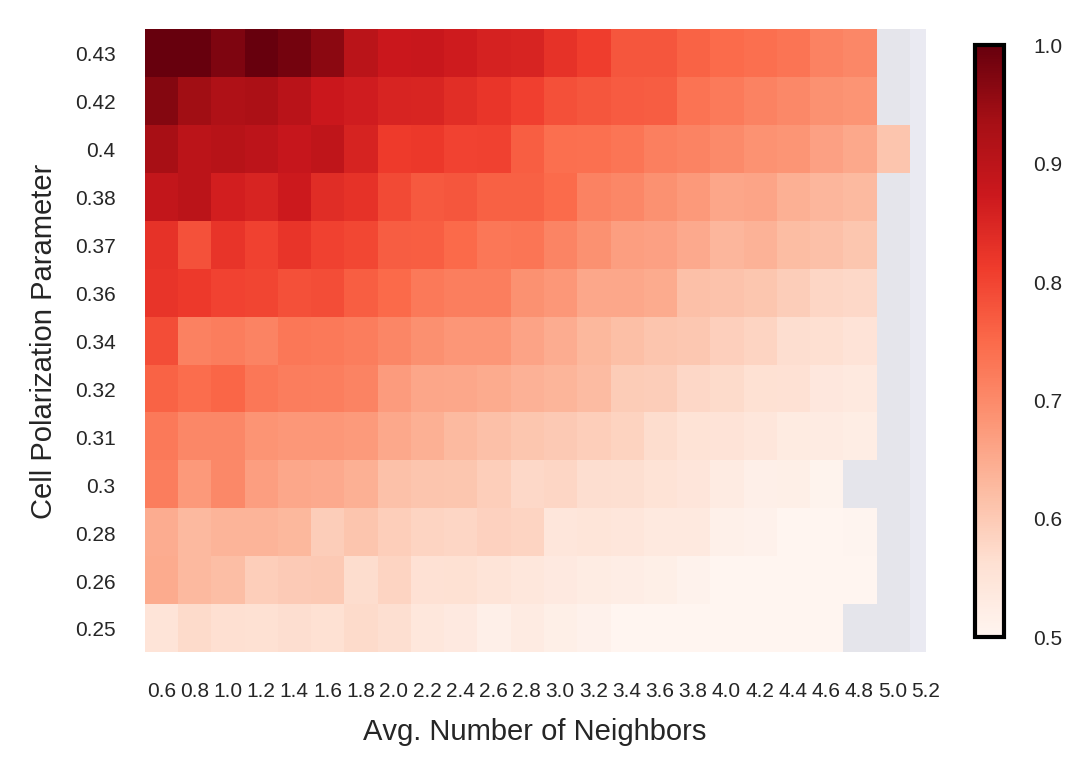

In [67]:
speed_mat = np.divide(heatmap_data,heatmap_cnt)

speed_mat_2 = copy.deepcopy(speed_mat[:13,2:ncolumns])
speed_vals = speed_mat_2[~np.isnan(speed_mat_2)]

ncolumns = 29-4

print "Max. Speed: " + repr(np.max(speed_vals))
print "Min. Speed: " + repr(np.min(speed_vals))

cmap = bmap.mpl_colormap
cmap.set_bad((0.9,0.9,0.925), 1.0)

plt.figure(figsize=(4.2,2.75), dpi=300)
plt.imshow(np.divide(speed_mat[:13,2:ncolumns], np.max(speed_vals)), cmap=cmap, vmin=0.5, vmax=1, aspect='auto')
cbar = plt.colorbar(extend='neither', spacing='proportional', orientation='vertical', shrink=0.95)
cbar.ax.tick_params(labelsize=5)
cbar.outline.set_edgecolor('black')
cbar.outline.set_linewidth(1)
#plt.clim(-4,4)
plt.gca().invert_yaxis()
plt.ylabel("Cell Polarization Parameter", size=7)
plt.xlabel("Avg. Number of Neighbors", size=7)
plt.xticks(range(ncolumns-1), np.round(x_dat[1:], 1))
plt.yticks(range(13), np.round(pol_vals, 2))
plt.tick_params(axis='both', which='major', labelsize=5)
plt.grid(False)
plt.savefig('Phase_Diag_Polarization_adh_a.eps', facecolor='w', edgecolor='w', transparent=True)

In [99]:
cmap = bmap.mpl_colormap
cmap.set_bad('blue', 1.0)
cmap._rgba_bad

(0.0, 0.0, 1.0, 1.0)

In [39]:
row = 4
col = 20

print "Polarization: " + repr(np.round(pol_vals[row-1],2))
print "Num neighbors: " + repr(np.round(x_dat[col],1))
print "Speed: " + repr(np.divide(speed_mat[row-1,col], np.max(speed_vals)))

Polarization: 0.29999999999999999
Num neighbors: 4.4000000000000004
Speed: 0.40507994210828119


a


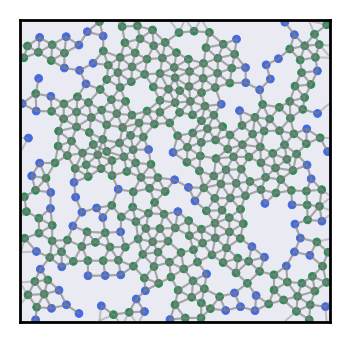

In [40]:
cnt = 0
disp_cnt = 0
disp_data = list()

prev_aval = None
prev_itr = None

keep_aval = 3

for sims in heatmap_dict[row-1,col]:
    #print sims
    
    if cnt > 10:
        continue
        
    pval = sims[0]
    aval = sims[1]
    itr = sims[2]
    
    #if int(aval) == keep_aval:
    #    print "Yay"
        
    if prev_aval is not None:
        if aval == prev_aval:
            continue
        
    prev_aval = aval
    
    if prev_itr is not None:
        if itr == prev_itr + 1:
            prev_itr += 1
            continue
            
    prev_itr = itr
    
    print aval
    folder = 'adh_pol_sweep' + os.sep + aval + '_adh_' + pval + '_pol'
    visualize_frame(folder, itr, True)
    disp_cnt += 1
    disp_data.append((folder,itr))
    cnt += 1

In [43]:
fig_num = 1
disp_data[fig_num-1]

('adh_pol_sweep/a_adh_4_pol', 1382)

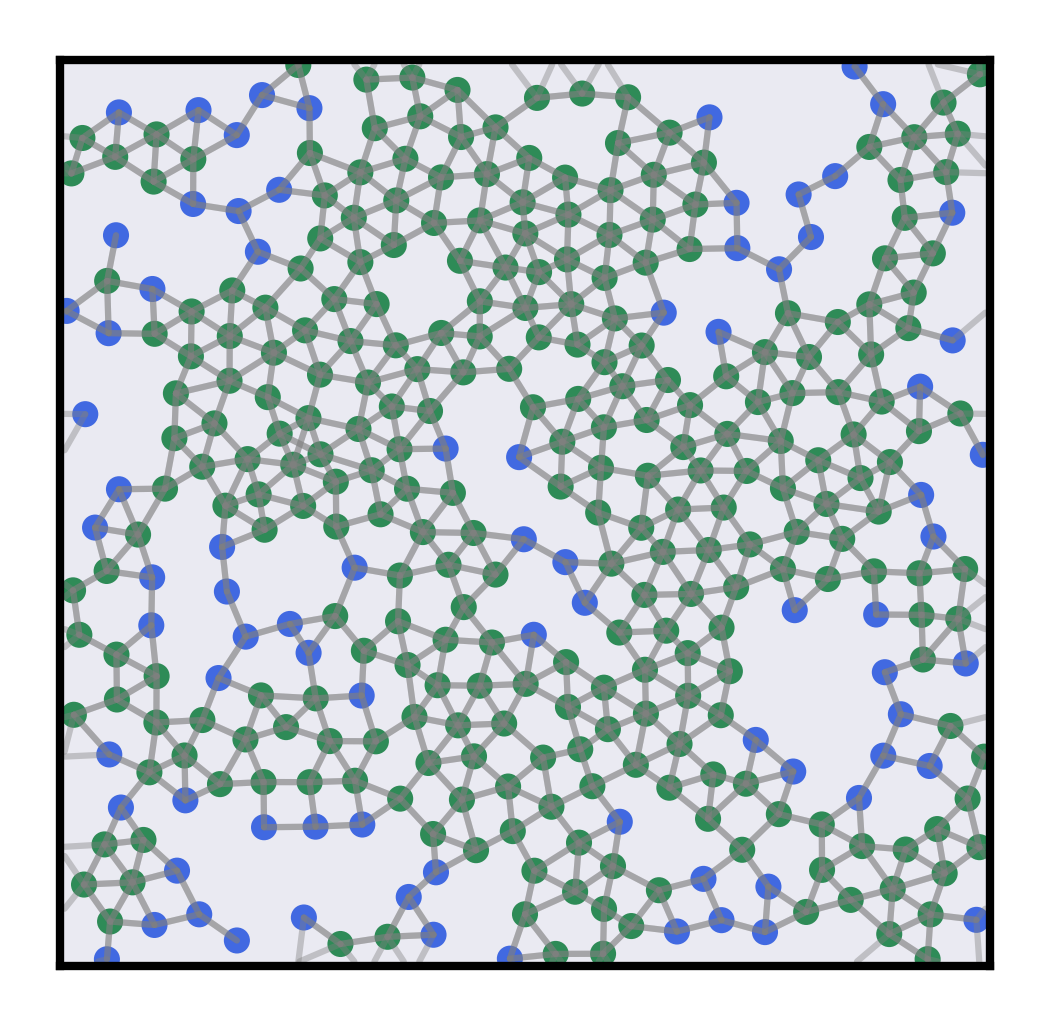

In [44]:
save_frame(disp_data[fig_num-1][0], disp_data[fig_num-1][1], 'row_4_col_20_adh_a_pol_4.pdf')

In [43]:
heatmap_data = np.zeros((10,29))
heatmap_cnt = np.zeros((10,29))

In [44]:
for index, row in df.iterrows():
    
    adhesion = row['adhesion']
    avgspeed = row['avg speed']
    avgnumneighbors = row['avg num neighbors']
    
    for key in adh_dict.keys():
        if adh_dict[key] == adhesion:
            break
    
    closestnumneighbors = min(x_dat, key=lambda x:abs(x-avgnumneighbors))
    for ind in range(len(x_dat)):
        if x_dat[ind] == closestnumneighbors:
            break
    
    heatmap_data[int(float(key))-1,ind] += avgspeed
    heatmap_cnt[int(float(key))-1,ind] += 1

/home/dbhaskar92/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in divide
  """Entry point for launching an IPython kernel.


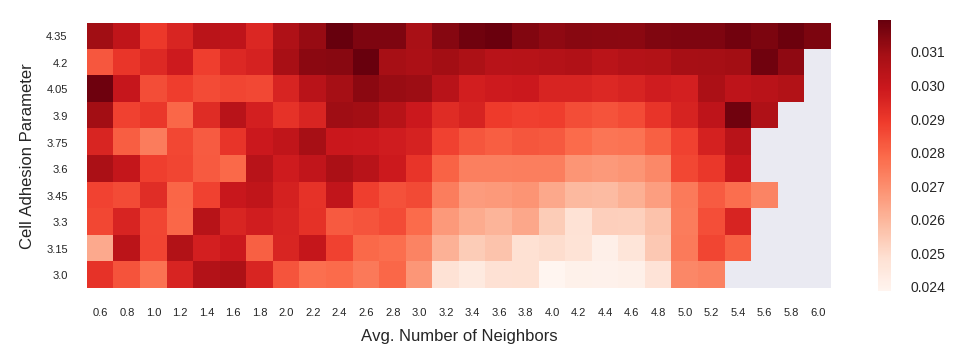

In [55]:
speed_mat = np.divide(heatmap_data,heatmap_cnt)

speed_vals = speed_mat[~np.isnan(speed_mat)]

plt.figure(figsize=(6,4), dpi=200)
plt.imshow(speed_mat[:,1:], cmap=bmap.mpl_colormap)
cbar = plt.colorbar(extend='neither', spacing='proportional', orientation='vertical', shrink=0.45)
cbar.ax.tick_params(labelsize=5)
plt.gca().invert_yaxis()
plt.ylabel("Cell Adhesion Parameter", size=6)
plt.xlabel("Avg. Number of Neighbors", size=6)
plt.xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27],
           np.round(x_dat[1:], 1))
plt.yticks([0,1,2,3,4,5,6,7,8,9], np.sort(adh_dict.values()))
plt.tick_params(axis='both', which='major', labelsize=4)
plt.grid(False)

In [12]:
subdf = df[df['polarization'] <= 0.43]
max_speed = np.max(subdf["avg speed"])
min_speed = np.min(subdf["avg speed"])
max_cells = np.max(subdf["number of cells"])
min_cells = np.min(subdf["number of cells"])

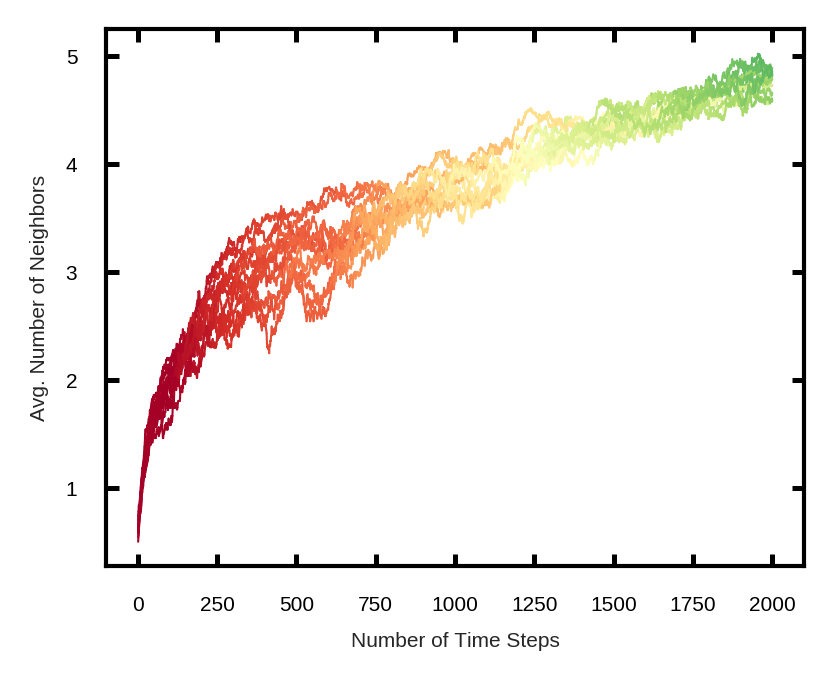

In [75]:
from matplotlib.collections import LineCollection

matplotlib.rc('xtick', labelsize=5) 
matplotlib.rc('ytick', labelsize=5) 
matplotlib.rcParams.update({'font.size':6})

plt.figure(figsize=(3, 2.37), dpi=300)
plt.rcParams['axes.facecolor'] = 'w'
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 1

max_speed = np.max(df["avg speed"])
min_speed = np.min(df["avg speed"])
max_cells = np.max(df["number of cells"])
min_cells = np.min(df["number of cells"])

for adh_key in adh_dict.keys(): 
    
    adh_val = adh_dict[adh_key]
    
    if adh_val != 3.0:
        continue
    
    for pol_key in pol_dict.keys():
        
        pol_val = pol_dict[pol_key]
        
        #if pol_key != '20':
        #    continue
        
        if pol_val > 0.43:
            continue
        
        idx_adh = np.where(df["adhesion"] == adh_val)[0]
        idx_pol = np.where(df["polarization"] == pol_val)[0]
        idx_common = list(set(idx_adh) & set(idx_pol))
        
        frame = df.iloc[idx_common,]["frame"].tolist()
        num_nbd = df.iloc[idx_common,]["avg num neighbors"].tolist()
        speed = df.iloc[idx_common,]["avg speed"].tolist()
        num_cells = df.iloc[idx_common,]["number of cells"].tolist()
        
        sort_idx = np.argsort(frame)
        frame_sorted = [frame[ix] for ix in sort_idx]
        num_nbd_sorted = [num_nbd[ix] for ix in sort_idx]
        speed_sorted = [speed[ix] for ix in sort_idx]
        num_cells_sorted = [num_cells[ix] for ix in sort_idx]
        min_spd_frame = np.min(speed_sorted)
        max_spd_frame = np.max(speed_sorted)
        
        num_cells_norm = np.divide(num_cells_sorted-min_cells, max_cells-min_cells)
        
        #speed_norm = np.divide(speed_sorted-min_speed, max_speed-min_speed)
        
        #print(len(cm.RdYlGn(num_cells_norm)))
        
        for cc in range(len(frame_sorted)-1):
            plt.plot(frame_sorted[cc:cc+2], num_nbd_sorted[cc:cc+2], lw=0.5, c=cm.RdYlGn(num_cells_norm)[cc:cc+1][0])
        
        #cdata = plt.cm.RdYlGn(num_cells_norm)
        #plt.scatter(frame_sorted, num_nbd_sorted, c=cdata, s=0.6)

plt.tick_params(top='on', right='on', which='both') 
ax = plt.gca()
ax.tick_params(axis='x', which='minor', bottom=True, top=True)
ax.tick_params(direction='in', length=3, width=1.2, colors='k')
ax.tick_params(direction='in', which='minor', length=3, width=1, colors='k')
plt.xlabel("Number of Time Steps", size=5)
plt.ylabel("Avg. Number of Neighbors", size=5)
plt.grid(True)
plt.savefig('Phase_Red_Green.eps', facecolor='w', edgecolor='w', transparent=True)

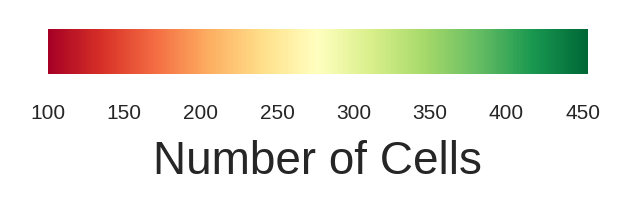

In [14]:
cmap = cm.RdYlGn
norm = matplotlib.colors.Normalize(vmin=min_cells, vmax=max_cells)

fig = plt.figure(figsize=(2, 1), dpi=300)
ax1 = fig.add_axes([0.05, 0.80, 0.9, 0.15])

cb1 = matplotlib.colorbar.ColorbarBase(ax1, cmap=cmap, norm=norm, orientation='horizontal')
cb1.set_label('Number of Cells')
cb1.ax.tick_params(labelsize=5)
plt.savefig('Phase_Red_Green_ColorBar.eps', facecolor='w', edgecolor='w', transparent=True)